In [ ]:
import joblib
from tqdm.keras import TqdmCallback

import numpy as np
import tensorflow as tf

from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from keras.layers import Dropout
from keras.utils import to_categorical
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint

from math import ceil

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from sklearn.utils import class_weight

import matplotlib.pyplot as plt

In [4]:
X_train = joblib.load('full/X_train')

X_test = joblib.load('full/X_test')

y_train = joblib.load('full/y_train')

y_test = joblib.load('full/y_test')

In [43]:
y_train_bin = np.array([1 if x == 'MI' else 0 for x in y_train])

y_test_bin = np.array([1 if x == 'MI' else 0 for x in y_test])

In [6]:
np.mean(y_train_bin), np.mean(y_test_bin)

(0.8327384123601492, 0.8100437922993801)

In [236]:
def equal_class_report(X_test, y_test, model):

    test_0 = [x for i,x in enumerate(X_test) if y_test[i] == 0]
    test_y0 = [0 for x in y_test if x == 0]

    rng = np.random.default_rng(1)
    index_list = rng.choice(14093, size=len(test_0), replace=False)

    test_1 = [X_test[i] for i in index_list]
    test_y1 = [1 for i in index_list]

    equal_X_test = np.array(test_0 + test_1)
    equal_y_test = np.array(test_y0 + test_y1)
    
    equal_y_pred = model.predict_classes(equal_X_test)
    
    print('ROC AUC: {}'.format(roc_auc_score(equal_y_test, equal_y_pred)))
    print(classification_report(equal_y_test, equal_y_pred))

# Modelling

In [10]:
class_weights = {i:x for i,x in enumerate(class_weight.compute_class_weight(class_weight='balanced', classes=[0,1], y=y_train_bin))}

In [5]:
reg = l2(0.00001)

In [224]:
checkpoint = ModelCheckpoint('200303_full_Bi_64_32_8_reg/model_cp', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

In [6]:
model = Sequential()

In [7]:
model.add(Bidirectional(LSTM(64, input_shape=(600,12), return_sequences=True, kernel_regularizer=reg, recurrent_regularizer=reg)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32, return_sequences=True, kernel_regularizer=reg, recurrent_regularizer=reg)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(8, kernel_regularizer=reg, recurrent_regularizer=reg)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='Nadam',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train_bin, class_weight=class_weights,
          batch_size=64, epochs=20,
          validation_data=(X_test, y_test_bin),
          verbose=0, callbacks=[TqdmCallback(verbose=1), checkpoint])

In [240]:
model.save('200303_full_Bi_64_32_8_reg/model_end')

In [241]:
joblib.dump(history, '200303_full_Bi_64_32_8_reg/history')

['200303_full_Bi_64_32_8_reg/history']

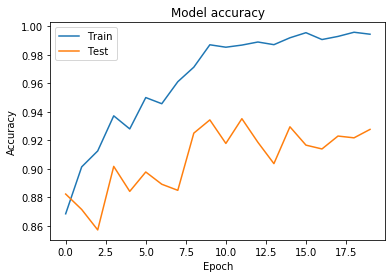

In [242]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

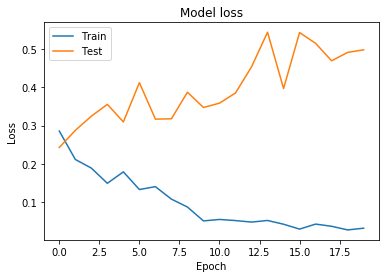

In [243]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [238]:
equal_class_report(X_test, y_test_bin, model)

ROC AUC: 0.8502994011976048
              precision    recall  f1-score   support

           0       0.89      0.79      0.84      3340
           1       0.81      0.91      0.86      3340

    accuracy                           0.85      6680
   macro avg       0.85      0.85      0.85      6680
weighted avg       0.85      0.85      0.85      6680

